<a href="https://colab.research.google.com/github/rachelhakes/Machine-Learning/blob/main/FINAL_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 3
This is the pipeline that produces the best result. The steps are as follows in this order:

*   Outlier Handling (iqr)
*   scaling (min-max)
*   normalization

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing
import seaborn as sns
# Import the necessary libraries first
#### Correlation method - for classification chi2 only
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#### RFE method - replace the model with the model you plan to use
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
#### feature importance method
#### this method can be used for both topK and cut-off
from sklearn.linear_model import Ridge
#### specifically tree-based feature importance method
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#### for voting
from collections import Counter

# import required packages for splitting data
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import required packages for evaluating models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#### you should change data_path to point to your OWN data file
data_path = '/content/drive/MyDrive/Classroom/pipeline.csv'
features_df = pd.read_csv(data_path, index_col=0)
features_df

,C1',C4,C5',C6',C7,T1',T2',T3',S1',S2',S3',S4',S5',S6'
0,2.086360,0.029074,3.864345,11.111111,51.345,0.640426,0.908876,0.054250,0.004875,0.009199,0.010929,0.529915,0.446043,0.841727
1,2.413300,-0.013352,12.028832,0.000000,25.936,0.644753,0.898724,0.051395,0.003258,0.011105,0.010876,0.293388,0.299578,1.021097
2,1.954243,0.020715,3.369134,0.000000,7.378,0.636816,0.909350,0.061764,0.011593,0.006271,0.011403,1.848485,1.016667,0.550000
3,2.320146,0.020023,3.299697,0.000000,8.526,0.539634,0.917060,0.061630,0.009686,0.007144,0.013319,1.355932,0.727273,0.536364
4,1.903090,-0.034895,3.726269,5.000000,632.298,0.587413,0.888469,0.048550,0.004518,0.010047,0.011261,0.449664,0.401198,0.892216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,2.501059,0.004670,3.963872,20.000000,186.101,0.612663,0.920952,0.050603,0.006512,0.007935,0.012950,0.820755,0.502890,0.612717
656,1.991226,0.058689,4.679726,0.000000,25.461,0.647177,0.906227,0.056770,0.005069,0.009124,0.012527,0.555556,0.404624,0.728324
657,2.049218,0.030425,3.673544,0.000000,55.431,0.647761,0.889600,0.047976,0.004191,0.009044,0.009926,0.463415,0.422222,0.911111
658,1.892095,0.032284,4.217684,18.750000,117.857,0.710938,0.909412,0.043178,0.006773,0.005362,0.014110,1.263158,0.480000,0.380000


In [ ]:
## Look at the skewness
features_df.skew(axis=0)

C1'     0.132069
C4     -0.477892
C5'    13.405536
C6'     4.372685
C7     12.163784
T1'    -1.595377
T2'    -5.993284
T3'     0.583379
S1'     0.935823
S2'     1.206660
S3'     1.395926
S4'     1.745261
S5'     1.037019
S6'     1.844150
dtype: float64

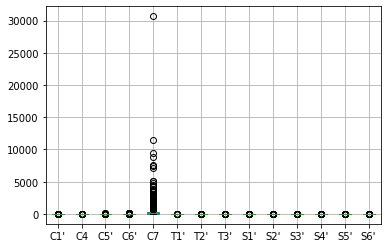

In [ ]:
features_df.boxplot();

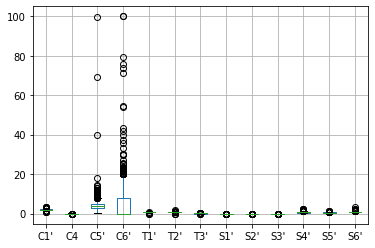

In [ ]:
# boxplots without C7
features_df[['C1\'', 'C4', 'C5\'', 'C6\'', 'T1\'', 'T2\'', 'T3\'', 'S1\'', 'S2\'', 'S3\'', 'S4\'', 'S5\'', 'S6\'']].boxplot();

In [ ]:
# First step is Outlier detection
def iqr(df):
  # loop through each of the dataframe columns
  for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)

    # set everything below lower bound to value of lower bound
    df[col][df[col] < lower_bound] = lower_bound
    # set everything above upper bound to value of upper bound
    df[col][df[col] > upper_bound] = upper_bound

  return df

In [ ]:
features_df = iqr(features_df)

In [ ]:
features_df

,C1',C4,C5',C6',C7,T1',T2',T3',S1',S2',S3',S4',S5',S6'
0,2.086360,0.029074,3.864345,11.111111,51.345,0.640426,0.908876,0.054250,0.004875,0.009199,0.010929,0.529915,0.446043,0.841727
1,2.413300,-0.013352,7.868826,0.000000,25.936,0.644753,0.898724,0.051395,0.003258,0.011105,0.010876,0.293388,0.299578,1.021097
2,1.954243,0.020715,3.369134,0.000000,7.378,0.636816,0.909350,0.061764,0.009440,0.006271,0.011403,1.242170,0.891960,0.550000
3,2.320146,0.020023,3.299697,0.000000,8.526,0.539634,0.917060,0.061630,0.009440,0.007144,0.013319,1.242170,0.727273,0.536364
4,1.903090,-0.034895,3.726269,5.000000,632.298,0.587413,0.888469,0.048550,0.004518,0.010047,0.011261,0.449664,0.401198,0.892216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,2.501059,0.004670,3.963872,19.230769,186.101,0.612663,0.920952,0.050603,0.006512,0.007935,0.012950,0.820755,0.502890,0.612717
656,1.991226,0.058689,4.679726,0.000000,25.461,0.647177,0.906227,0.056770,0.005069,0.009124,0.012527,0.555556,0.404624,0.728324
657,2.049218,0.030425,3.673544,0.000000,55.431,0.647761,0.889600,0.047976,0.004191,0.009044,0.009926,0.463415,0.422222,0.911111
658,1.892095,0.032284,4.217684,18.750000,117.857,0.710938,0.909412,0.043178,0.006773,0.005362,0.014110,1.242170,0.480000,0.380000


In [ ]:
features_df.min()

C1'    1.537002
C4    -0.082174
C5'    0.283223
C6'    0.000000
C7     0.074000
T1'    0.439132
T2'    0.844003
T3'    0.034170
S1'    0.001602
S2'    0.002152
S3'    0.005326
S4'    0.133333
S5'    0.130802
S6'    0.244755
dtype: float64

In [ ]:
# STANDARDIZATION/SCALING
# We use the MinMaxScaler() to standardize the features
# We do not require normal or assume distribution
# This is our second step of the pipeline where we use MinMaxScaler()

def min_max(df):
  min_max_scaler = preprocessing.MinMaxScaler()
  names = df.columns
  d = min_max_scaler.fit_transform(df)
  x_scaled = pd.DataFrame(d, columns=names)
  return x_scaled

In [ ]:
features_df = min_max(features_df)

In [ ]:
features_df

,C1',C4,C5',C6',C7,T1',T2',T3',S1',S2',S3',S4',S5',S6'
0,0.524975,0.635450,0.472094,0.577778,0.074344,0.534607,0.617232,0.562279,0.417518,0.514293,0.450884,0.357655,0.414160,0.470946
1,0.837405,0.393113,1.000000,0.000000,0.037500,0.546102,0.520640,0.482346,0.211258,0.653417,0.446620,0.144345,0.221736,0.612450
2,0.398722,0.587702,0.406811,0.000000,0.010591,0.525021,0.621738,0.772690,1.000000,0.300628,0.489029,1.000000,1.000000,0.240805
3,0.748386,0.583750,0.397658,0.000000,0.012256,0.266919,0.695095,0.768942,1.000000,0.364297,0.643249,1.000000,0.783636,0.230048
4,0.349840,0.270058,0.453892,0.260000,0.916733,0.393812,0.423070,0.402686,0.372002,0.576213,0.477637,0.285282,0.355243,0.510777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.921269,0.496050,0.485215,1.000000,0.269742,0.460874,0.732125,0.460156,0.626502,0.422030,0.613574,0.619948,0.488845,0.290282
656,0.434064,0.804609,0.579585,0.000000,0.036811,0.552539,0.592028,0.632871,0.442297,0.508818,0.579538,0.380779,0.359744,0.381484
657,0.489482,0.643167,0.446942,0.000000,0.080268,0.554090,0.433825,0.386611,0.330298,0.502977,0.370210,0.297683,0.382864,0.525683
658,0.339332,0.653786,0.518675,0.975000,0.170787,0.721877,0.622324,0.252241,0.659741,0.234251,0.706950,1.000000,0.458772,0.106694


In [ ]:
features_df.min()

C1'    0.0
C4     0.0
C5'    0.0
C6'    0.0
C7     0.0
T1'    0.0
T2'    0.0
T3'    0.0
S1'    0.0
S2'    0.0
S3'    0.0
S4'    0.0
S5'    0.0
S6'    0.0
dtype: float64

In [ ]:
# Normalization
# Last process is the normalization of this pipeline
def power_transformer(df, method='yeo-johnson'):
  #think about the hardcoded colums

  pt = PowerTransformer(method=method, standardize=False)
  features_trans = pt.fit_transform(df)
  return pd.DataFrame(features_trans, columns=['C1\'', 'C4', 'C5\'', 'C6\'', 'C7', 'T1\'', 'T2\'', 'T3\'', 'S1\'', 'S2\'', 'S3\'', 'S4\'', 'S5\'', 'S6\''])



In [ ]:
features_df = power_transformer(features_df)

In [ ]:
features_df.min()

C1'    0.0
C4     0.0
C5'   -0.0
C6'   -0.0
C7    -0.0
T1'    0.0
T2'    0.0
T3'    0.0
S1'   -0.0
S2'   -0.0
S3'   -0.0
S4'   -0.0
S5'   -0.0
S6'   -0.0
dtype: float64

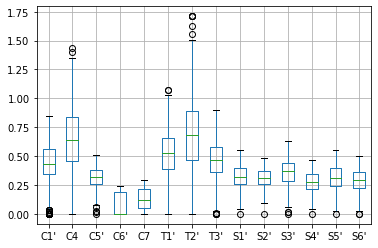

In [ ]:
# boxplot for visualization
features_df[['C1\'', 'C4', 'C5\'', 'C6\'', 'C7', 'T1\'', 'T2\'', 'T3\'', 'S1\'', 'S2\'', 'S3\'', 'S4\'', 'S5\'', 'S6\'']].boxplot();

In [ ]:
#### import categorical dataframe
data_path = '/content/drive/MyDrive/Classroom/DATA 6545: Machine Learning for Predictive Analysis SP2022/categorical_df.csv'
categorical_df = pd.read_csv(data_path, index_col=0)
categorical_df.head()

,C2,C3',I4_Manufacturing,I4_Others,I4_Service,I5_Non-techs,I5_Tech
0,1,1,1,0,0,0,1
1,0,0,1,0,0,1,0
2,1,0,1,0,0,1,0
3,1,0,1,0,0,1,0
4,1,1,0,1,0,1,0


In [ ]:
features_final = pd.concat([features_df, categorical_df], axis=1, join='inner')
features_final

,C1',C4,C5',C6',C7,T1',T2',T3',S1',S2',S3',S4',S5',S6',C2,C3',I4_Manufacturing,I4_Others,I4_Service,I5_Non-techs,I5_Tech
0,0.476263,0.812673,0.324364,0.214293,0.064456,0.558137,0.880238,0.527471,0.310796,0.332613,0.353016,0.255588,0.309334,0.320221,1,1,1,0,0,0,1
1,0.725393,0.461399,0.509756,-0.000000,0.034836,0.570597,0.706297,0.456084,0.179757,0.385485,0.350369,0.124411,0.187448,0.379905,0,0,1,0,0,1,0
2,0.369314,0.739487,0.292113,-0.000000,0.010369,0.547759,0.888695,0.710865,0.553344,0.228020,0.376255,0.469256,0.554764,0.194091,1,0,1,0,0,1,0
3,0.656438,0.733517,0.287358,-0.000000,0.011959,0.273137,1.030714,0.707652,0.553344,0.262803,0.462952,0.469256,0.479893,0.187041,1,0,1,0,0,1,0
4,0.326779,0.302404,0.315654,0.152811,0.284126,0.406966,0.544654,0.383903,0.284732,0.357360,0.369396,0.216461,0.275091,0.338151,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.789030,0.604460,0.330514,0.240923,0.169982,0.478631,1.105533,0.436085,0.414513,0.291511,0.447104,0.365460,0.349465,0.225002,1,0,0,0,1,1,0
656,0.399664,1.087503,0.371829,-0.000000,0.034241,0.577583,0.833500,0.589700,0.324402,0.330322,0.428459,0.267137,0.277795,0.276181,1,0,1,0,0,0,1
657,0.446602,0.824684,0.312272,-0.000000,0.068845,0.579266,0.561786,0.369205,0.259547,0.327858,0.301170,0.223508,0.291448,0.344620,0,1,1,0,0,0,1
658,0.317548,0.841293,0.345731,0.240039,0.125364,0.763228,0.889796,0.244478,0.428972,0.187717,0.495761,0.469256,0.333718,0.096412,1,1,0,1,0,1,0


In [ ]:
#### you should change data_path to point to your OWN data file
data_path = '/content/drive/MyDrive/Classroom/DATA 6545: Machine Learning for Predictive Analysis SP2022/targetvariables.csv'
target_variables = pd.read_csv(data_path, index_col=0)
target_variables.head()

,Y1,Y2
0,0,1
1,1,0
2,1,0
3,1,1
4,0,1


# Feature Selection

In [ ]:
X = features_final.values
y1 = target_variables.Y1.values
y2 = target_variables.Y2.values

In [ ]:
names = ['C1\'', 'C4', 'C5\'', 'C6\'', 'C7', 'T1\'', 'T2\'', 'T3\'', 'S1\'', 'S2\'', 'S3\'', 'S4\'', 'S5\'', 'S6\'','C2','C3\'', 'I4_Manufacturing', 'I4_Others', 'I4_Service', 'I5_Non-techs', 'I5_Tech']

In [ ]:
clf = RandomForestClassifier()

In [ ]:
def feature_selector(X, y, model, names, _method="topk", n=int(X.shape[1]/2), fit_X=False, thres = 0.1):
  """voting based feature selector
  - _method: "topk" for top-K method (default), "cutoff" for cut-off based method
  - n: number of features to be selected. only available for top-K method - default half of the total features
  - thres: cut-off threshold (default 0.1), only availabel for cutoff method
  - fit_X: fit_transform X or just return indices
  TODO: include support for regression problems
  """
  #### Placeholder for tests
  # X.shape[0] == y.shape[0]
  if names: # if given feature names
    feature_names = np.array(names)
  else: # otherwise use location
    feature_names = np.array(["X%s" % x for x in range(len(X.shape[0]))])
  if _method == 'topk':
    #### np.argpartition gets the indices of the largest n element from the array in ascending order
    #### [::-1] reverse the order
    corr_features = list(np.argpartition(SelectKBest(score_func=chi2, k=n).fit(X,y).scores_, -n)[-n:][::-1])
    #corr_features = []
    #### binary masking on features, use np.where() to get the indices of selected
    rfe_features = list(np.where(RFE(model, n_features_to_select=n, step=1).fit(X, y).support_)[0])
    #### argsort get sorted indices by values, ::-1] reverse the asceding order
    ridge_features = list(np.argsort(Ridge(alpha=1.0).fit(X, y).coef_)[-n:][::-1])
    #### using ExtraTree
    extratree_features = list(np.argsort(ExtraTreesClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    ### using Random Forest:
    rf_features = list(np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    print("Using the Top-K method: ")
    print("Selected features by correlation: ", feature_names[corr_features])
    print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  elif _method == 'cutoff':
    corr_features, rfe_features = list(), list() #### N/A
    ridge_features = list(np.where(Ridge(alpha=1.0).fit(X, y).coef_ > thres)[0])
    extratree_features = list(np.where(ExtraTreesClassifier().fit(X, y).feature_importances_ > thres)[0])
    rf_features = list(np.where(RandomForestClassifier().fit(X, y).feature_importances_ > thres)[0])
    print("Using the Cutoff method: ")
    # print("Selected features by correlation: ", feature_names[corr_features])
    # print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  else:
    return("Only Top-K and Cutoff methods are currently supported!")
  ######################################
  #### combine results using voting ####
  ######################################
  counted = Counter(np.concatenate((corr_features, rfe_features, ridge_features, extratree_features, rf_features), axis=None)).most_common(n)
  #### list of tuples (feature_index, votes)
  counted.sort(key = lambda x: x[1], reverse=True)
  final_select_series = pd.Series({feature_names[int(f)]:c for f,c in counted}).sort_values(ascending=False)
  selected_idx = sorted([int(f) for f,c in counted])
  assert len(selected_idx) == n
  print(final_select_series)
  #print(selected_idx)
  if fit_X:
    return(X[:,selected_idx])
  else:
    return(feature_names[selected_idx])

In [ ]:
x_selected_y1 = feature_selector(X, y1, model=clf, names=names, fit_X=True)
x_selected_y1

Using the Top-K method: 
Selected features by correlation:  ['I5_Tech' 'I5_Non-techs' "C6'" "C3'" "T2'" 'I4_Manufacturing' "T3'"
 'I4_Service' 'C2' "S2'"]
Selected features by RFE:  ['C4' "C5'" "C6'" 'C7' "T1'" "T2'" "T3'" "S1'" "S2'" "S6'"]
Selected features by Ridge coefficients:  ["S2'" "T1'" "S5'" "S6'" "S1'" "T2'" "S3'" "C5'" "T3'" "C1'"]
Selected features by Extra Tree feature importance:  ["C6'" "S2'" "S6'" "T2'" "T3'" 'C4' "S1'" "S4'" "T1'" "C5'"]
Selected features by Random Forest feature importance:  ["C6'" "S2'" "S6'" "T3'" "T2'" 'C4' 'C7' "S1'" "C5'" "T1'"]
T2'    5
T3'    5
S2'    5
C6'    4
C5'    4
T1'    4
S1'    4
S6'    4
C4     3
C7     2
dtype: int64


array([[ 0.81267344,  0.32436371,  0.21429305, ...,  0.31079556,
         0.33261293,  0.32022055],
       [ 0.46139866,  0.50975645, -0.        , ...,  0.17975737,
         0.38548515,  0.37990533],
       [ 0.73948734,  0.29211293, -0.        , ...,  0.55334351,
         0.22801951,  0.19409102],
       ...,
       [ 0.8246839 ,  0.31227164, -0.        , ...,  0.25954697,
         0.32785751,  0.34462033],
       [ 0.84129267,  0.34573139,  0.24003853, ...,  0.42897184,
         0.18771716,  0.0964121 ],
       [ 0.77402362,  0.28325632,  0.17681417, ...,  0.49393599,
         0.32128989,  0.24313875]])

In [ ]:
x_selected_y2 = feature_selector(X, y2, model=clf, names=names, fit_X=True)
x_selected_y2

Using the Top-K method: 
Selected features by correlation:  ['I5_Tech' 'I5_Non-techs' 'I4_Service' 'I4_Others' 'I4_Manufacturing'
 "C6'" 'C4' 'C2' "S6'" "S2'"]
Selected features by RFE:  ['C4' "C5'" "C6'" "T1'" "T2'" "T3'" "S2'" "S3'" "S5'" "S6'"]
Selected features by Ridge coefficients:  ["C6'" "S4'" "S3'" 'C4' "C5'" 'C2' 'I4_Service' 'I4_Manufacturing' "S6'"
 'I5_Tech']
Selected features by Extra Tree feature importance:  ["C6'" 'C4' "S2'" "C5'" "S6'" 'C7' "T1'" "S4'" "T3'" "C1'"]
Selected features by Random Forest feature importance:  ['C4' "C5'" "T2'" "S2'" "S6'" "T3'" "T1'" "C6'" "S5'" "S3'"]
C6'           5
C4            5
S6'           5
S2'           4
C5'           4
T1'           3
T3'           3
S3'           3
I5_Tech       2
I4_Service    2
dtype: int64


array([[ 0.81267344,  0.32436371,  0.21429305, ...,  0.32022055,
         0.        ,  1.        ],
       [ 0.46139866,  0.50975645, -0.        , ...,  0.37990533,
         0.        ,  0.        ],
       [ 0.73948734,  0.29211293, -0.        , ...,  0.19409102,
         0.        ,  0.        ],
       ...,
       [ 0.8246839 ,  0.31227164, -0.        , ...,  0.34462033,
         0.        ,  1.        ],
       [ 0.84129267,  0.34573139,  0.24003853, ...,  0.0964121 ,
         0.        ,  0.        ],
       [ 0.77402362,  0.28325632,  0.17681417, ...,  0.24313875,
         0.        ,  0.        ]])

In [ ]:
features_concat = pd.concat([features_df, categorical_df, target_variables], axis=1, join='inner')
features_concat

,C1',C4,C5',C6',C7,T1',T2',T3',S1',S2',S3',S4',S5',S6',C2,C3',I4_Manufacturing,I4_Others,I4_Service,I5_Non-techs,I5_Tech,Y1,Y2
0,0.476263,0.812673,0.324364,0.214293,0.064456,0.558137,0.880238,0.527471,0.310796,0.332613,0.353016,0.255588,0.309334,0.320221,1,1,1,0,0,0,1,0,1
1,0.725393,0.461399,0.509756,-0.000000,0.034836,0.570597,0.706297,0.456084,0.179757,0.385485,0.350369,0.124411,0.187448,0.379905,0,0,1,0,0,1,0,1,0
2,0.369314,0.739487,0.292113,-0.000000,0.010369,0.547759,0.888695,0.710865,0.553344,0.228020,0.376255,0.469256,0.554764,0.194091,1,0,1,0,0,1,0,1,0
3,0.656438,0.733517,0.287358,-0.000000,0.011959,0.273137,1.030714,0.707652,0.553344,0.262803,0.462952,0.469256,0.479893,0.187041,1,0,1,0,0,1,0,1,1
4,0.326779,0.302404,0.315654,0.152811,0.284126,0.406966,0.544654,0.383903,0.284732,0.357360,0.369396,0.216461,0.275091,0.338151,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.789030,0.604460,0.330514,0.240923,0.169982,0.478631,1.105533,0.436085,0.414513,0.291511,0.447104,0.365460,0.349465,0.225002,1,0,0,0,1,1,0,0,1
656,0.399664,1.087503,0.371829,-0.000000,0.034241,0.577583,0.833500,0.589700,0.324402,0.330322,0.428459,0.267137,0.277795,0.276181,1,0,1,0,0,0,1,0,0
657,0.446602,0.824684,0.312272,-0.000000,0.068845,0.579266,0.561786,0.369205,0.259547,0.327858,0.301170,0.223508,0.291448,0.344620,0,1,1,0,0,0,1,0,1
658,0.317548,0.841293,0.345731,0.240039,0.125364,0.763228,0.889796,0.244478,0.428972,0.187717,0.495761,0.469256,0.333718,0.096412,1,1,0,1,0,1,0,1,0


# DataFrame Selected for Evaluation

In [ ]:
# make dataframe with top features from feature selection
selected_y1 = features_concat[['T3\'', 'S2\'', 'C6\'','I5_Tech', 'Y1', 'Y2']]
selected_y1.head()


,T3',S2',C6',I5_Tech,Y1,Y2
0,0.527471,0.332613,0.214293,1,0,1
1,0.456084,0.385485,-0.000000,0,1,0
2,0.710865,0.228020,-0.000000,0,1,0
3,0.707652,0.262803,-0.000000,0,1,1
4,0.383903,0.357360,0.152811,0,0,1


# Evaluation Code

In [ ]:
# define features and target
X = selected_y1.iloc[:,:-2].values
y = selected_y1.iloc[:,-2].values
# if you want a secondary target
### y1 = ...

In [ ]:
### y should be binary
assert len(np.unique(y)) == 2

In [ ]:
X.shape, y.shape

((639, 4), (639,))

In [ ]:
# balance the data
from imblearn.over_sampling import SMOTE
# resample/balance the data
# note although we do not balance data this way,
# this works the best for this project
sm = SMOTE(random_state = 2022)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
# import `logistic regression` model
from sklearn.linear_model import LogisticRegression
# define the model
clf = LogisticRegression(max_iter=2000)

In [ ]:
def my_eval(X, y, classifer = clf, k=10, scoring = 'f1'):
  '''
  return evaluation results (f1-score or ROC_AUC).
  Built in k-fold evaluation.
  INPUTS:
  ----
  - X: features; DataFrame or Numpy ndarray;
  - y: target; DataFrame or Numpy ndarray;
  - classifier: any sklearn (or its add-on) based classifier
  - k: number of folds in cross validation
  - scoring: evaluation metric ('f1' default or 'roc_auc')
  OUTPUT:
  ----
  bias/variance score of selected metric. Both lower the better
  - bias: mean of the metric over cross validation, measure the accruracy
  - variance: std.ev. of the metric, measure the consistency.
  '''
  scores = []
  for i in range(100):
    #### generate random numbers to shuffle the data for training and test
    np.random.seed(2021)
    random_int = np.random.randint(0,3000)
    #### create cross validation folds
    kfold = model_selection.KFold(n_splits=k, random_state=random_int, shuffle=True)
    #### record the score
    score = model_selection.cross_val_score(clf, X=X, y=y, cv=kfold, scoring=scoring)
    scores.append(score)
  scores = np.array(scores)
  #### we need to calculate the bias (average score) and viariance (std)
  bias, variance = 1 - round(scores.mean(),4), round(scores.std(),4)
  return(bias, variance)

In [ ]:
# getting averaged f1_score from 10-fold CV (default)
my_eval(X_res, y_res, clf, 10)

(0.5424, 0.0783)

In [ ]:
# getting averaged ROC_AUC from 10-fold CV
my_eval(X_res, y_res, clf, 10, 'roc_auc')

(0.5246999999999999, 0.0779)